# Capstone Project (Wizeline Bootcamp)
## Air Quality Dataset Analysis
### Daniel Martínez Escobosa (Correcciones Entrega 1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from scipy.stats import skew, kurtosis
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## <b>Cargando el dataset</b>

In [2]:
#Se importa dataset
#raw_data = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',',parse_dates=[['Date','Time']])
raw_data = pd.read_csv('C:/Users/daniel.martinez/OneDrive - TIERRA Y ARMONIA CONSTRUCCION SA DE CV/Escritorio/Data Scientist TyA/Bootcamp MLOPs Wizeline/proyecto_ind_dme/airquality/data/raw/AirQualityUCI.csv', sep=';', decimal=',',parse_dates=[['Date','Time']])
#Se visualiza que figuran dos columnas extra (nulas) al extremo derecho de la matriz tabular que hay que remover
raw_data = raw_data.iloc[:, :-2]
#Procediendo a eliminar filas del dataset se asegura tener el dataset limpios de filas y columnas llenas de valores nulos y lograr la coincidencia de dimensión del dataset según la bibliografía.
raw_data = raw_data.head(9357)

## <b>Data Prepare</b>
Lidiando con la información faltante del dataset

In [3]:
#Y ahora se reemplazan dichos valores a NaN para poder estudiar la distribución de información no nula de cada variable y poder proponer un método de imputación adecuado a cada caso
trusted_data = raw_data.replace(to_replace = -200, value = np.NaN)

#Alternativa 1. Imputación de datos faltantes. Se define criterio individual para cada variable según su distribución.
imputation_methods = {
    'CO(GT)': 'median',
    'NOx(GT)': 'mean',
    'NO2(GT)': 'mean',
    'PT08.S4(NO2)': 'mean',
    'PT08.S5(O3)': 'mean',
    'T': 'mean',
    'RH': 'mean',
    'AH': 'mean'
}

# Se itera sobre el diccionario y se aplica el método de imputación correspondiente a cada columna
for column, method in imputation_methods.items():
    if method == 'mean':
        trusted_data[column].fillna(trusted_data[column].mean(), inplace=True)
    elif method == 'median':
        trusted_data[column].fillna(trusted_data[column].median(), inplace=True)
    elif method == 'mode':
        trusted_data[column].fillna(trusted_data[column].mode()[0], inplace=True)
    else:
        print(f'Método de imputación no válido para la columna {column}: {method}')


## <b>Feature Processing</b>

In [4]:
#Observando que la variable NMHC tiene demasiados valores faltantes (90.23% son faltantes), y ninguno de los métodos de imputación probados arrojan buenos resultados, quitamos del dataset. Nota: si más adelante no se obtienen buenos resultados con los modelos, podríamos regresar a rescatar la variable  avanzados como interpolación o modelos de machine learning. Date time también se elimina dado que no interesa en el ejercicio realizar un modelo de serie de tiempo.
trusted_data = trusted_data.drop(['NMHC(GT)','Date_Time'],axis='columns')
#Se establece empíricamente el umbral de abs(corr)>=0.8 y se observan variables altamente correlacionada, por lo que se descartan del análisis.
trusted_data = trusted_data.drop(['C6H6(GT)','PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)'],axis='columns')
trusted_data.head()

,CO(GT),NOx(GT),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,166.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,103.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,131.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,172.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,131.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### <b>Tratamiento Outliers del dataset</b>

In [5]:
#Tratamiento Outliers. 
#Se define función que da tratamiento a outliers previo a realizar transformaciones de datos para buscar distribuciones lo más simétricas posibles (cercanas a 0 en skew)
def remove_outliers(dataframe):
    """
    Elimina outliers de un DataFrame de pandas basado en la regla de 3 desviaciones estándar.
    
    """
    dataframe_cleaned = dataframe.copy()
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            mean = dataframe[column].mean()
            std_dev = dataframe[column].std()
            
            # Calcular límites para identificar outliers
            cut_off = std_dev * 4
            lower, upper = mean - cut_off, mean + cut_off
            
            # Filtrar outliers
            dataframe_cleaned = dataframe_cleaned[(dataframe_cleaned[column] > lower) & (dataframe_cleaned[column] < upper)]
    
    return dataframe_cleaned

# Se aplica la función al dataframe y se imprime también reporte de plots
trusted_data = remove_outliers(trusted_data)

### <b>Exploración del dataset a través de estadística descriptiva al dataset</b>

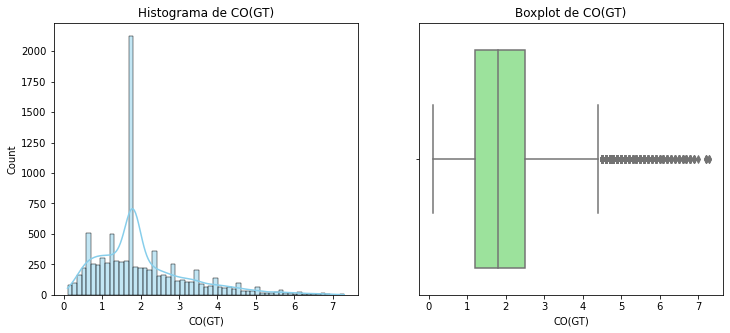

Variable: CO(GT)
Skewness: 1.23
Kurtosis: 1.70
Número de outliers: 10



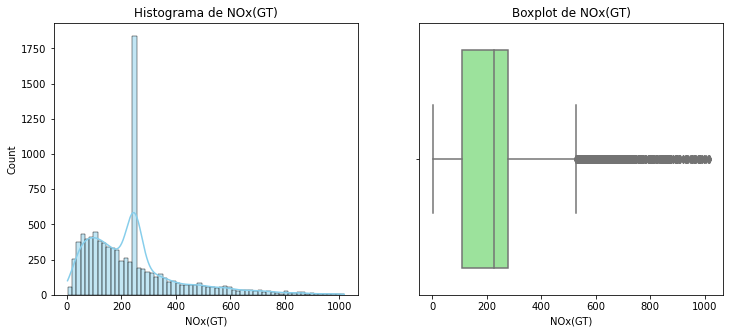

Variable: NOx(GT)
Skewness: 1.53
Kurtosis: 2.73
Número de outliers: 37



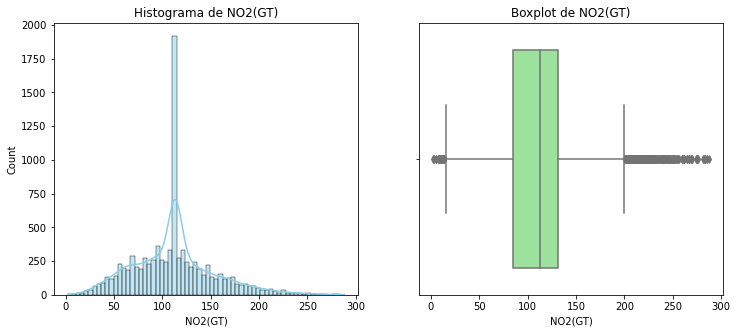

Variable: NO2(GT)
Skewness: 0.54
Kurtosis: 0.77
Número de outliers: 7



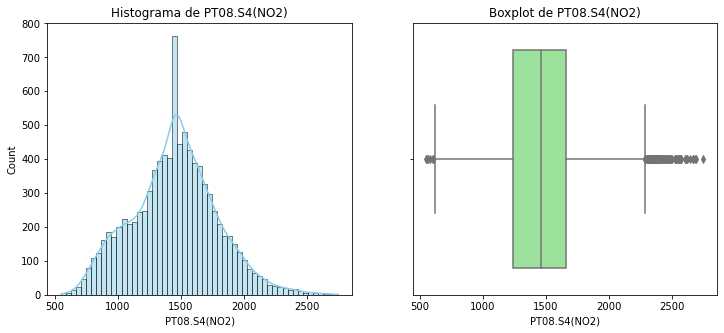

Variable: PT08.S4(NO2)
Skewness: 0.16
Kurtosis: 0.09
Número de outliers: 0



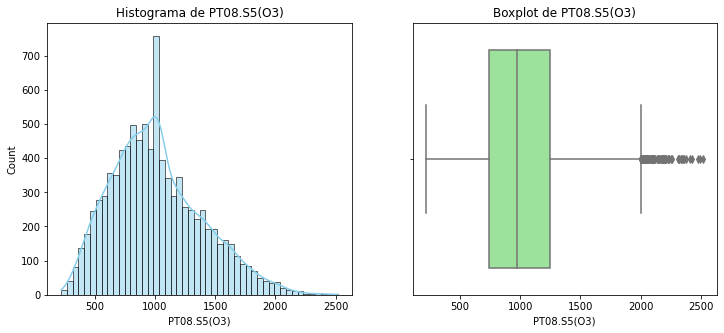

Variable: PT08.S5(O3)
Skewness: 0.56
Kurtosis: 0.02
Número de outliers: 0



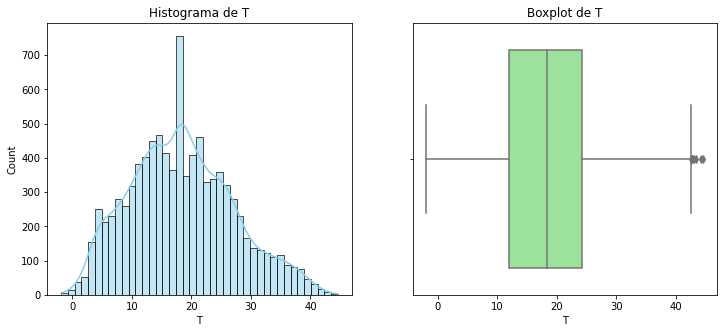

Variable: T
Skewness: 0.31
Kurtosis: -0.36
Número de outliers: 0



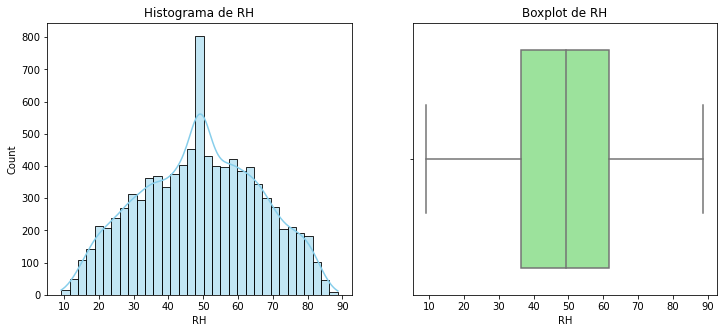

Variable: RH
Skewness: -0.03
Kurtosis: -0.74
Número de outliers: 0



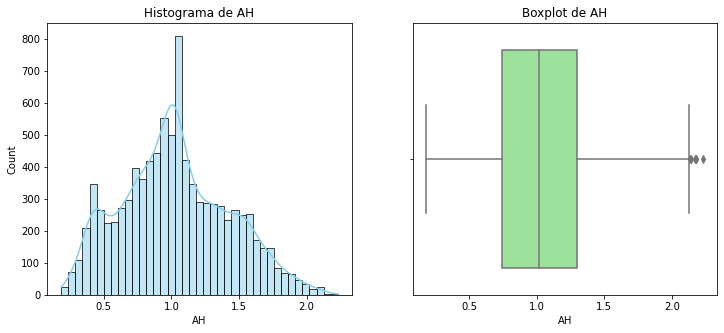

Variable: AH
Skewness: 0.25
Kurtosis: -0.46
Número de outliers: 0



In [6]:
# Graficar histogramas y boxplots, y calcular sesgo, curtosis y número de registros outliers

def plot_hist_boxplot_skew_kurt_outliers(dataframe):
    """
    Esta función grafica histogramas y boxplots para cada columna del DataFrame,
    calcula y muestra la skewness y la kurtosis para los valores no nulos de cada columna,
    e identifica outliers asumiendo como tal a aquel dato que esté por fuera de 3 desviaciones estándar de la media.
    
    """
    for column in dataframe.columns:
        plt.figure(figsize=(12, 5))
        
        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[column], kde=True, color='skyblue')
        plt.title(f'Histograma de {column}')
        
        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=dataframe[column], color='lightgreen')
        plt.title(f'Boxplot de {column}')
        
        plt.show()

        # Filtrar valores no nulos
        non_null_values = dataframe[column].dropna()

        # Calcular y mostrar skewness y kurtosis
        skewness = skew(non_null_values)
        kurt = kurtosis(non_null_values)
        print(f'Variable: {column}')
        print(f'Skewness: {skewness:.2f}')
        print(f'Kurtosis: {kurt:.2f}')

        # Calcular el número de outliers
        mean = non_null_values.mean()
        std = non_null_values.std()
        outliers = non_null_values[(non_null_values < (mean - 4 * std)) | (non_null_values > (mean + 4 * std))]
        print(f'Número de outliers: {len(outliers)}')
        print()

plot_hist_boxplot_skew_kurt_outliers(trusted_data)

### Estudiando correlaciones entre diferentes gases

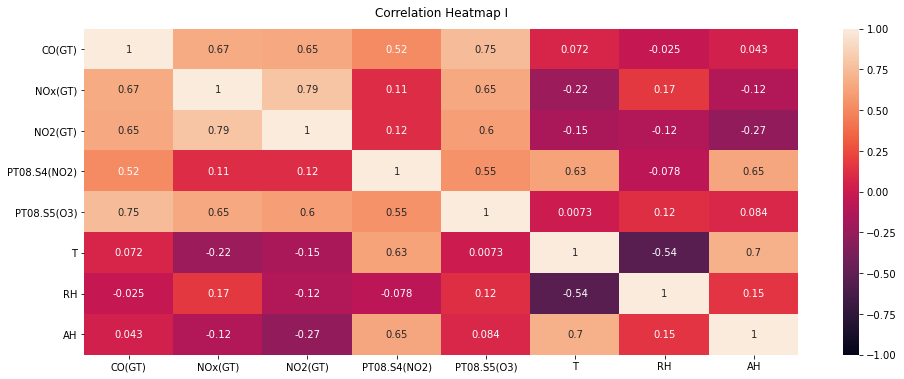

In [7]:
#Se visualizan correlaciones entre variables para estudio y entendimiento de datos
import seaborn as sb
plt.figure(figsize=(16, 6))
heatmap = sb.heatmap(trusted_data.corr(method='spearman'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap I', fontdict={'fontsize':12}, pad=12);


### <b>Transformación de datos del dataset</b>
Transformación Box-Cox.

In [8]:
#Transformaciones para mitigar sesgo
#Se propone la transformación boxcox para lidiar con el sesgo dañino previo a entrenamiento de modelos.
def transform_box_cox(x):
    """
    Aplica la transformación Box-Cox a las columnas de un DataFrame
    cuyo skew sea superior a 1.25 o menor a -1.25. Imprime las variables transformadas,
    su skew antes y después de la transformación, y el valor de lambda utilizado.
    Indica si no fue necesario realizar ninguna transformación.

    Parámetros:
    - trusted_data: DataFrame de pandas con variables numéricas.

    Retorna:
    - DataFrame con las transformaciones aplicadas.
    """
    # Variable para rastrear si alguna columna fue transformada
    transformation_applied = False

    for column in trusted_data.columns:
        # Verificar que la columna sea de tipo numérico
        if pd.api.types.is_numeric_dtype(trusted_data[column]):
            skewness_before = trusted_data[column].skew()
            # Verificar el skewness de la columna
            if skewness_before > 1.25 or skewness_before < -1.25:
                # Asegurarse de que todos los valores sean positivos
                if all(trusted_data[column] > 0):
                    # Aplicar la transformación Box-Cox
                    transformed_data, best_lambda = stats.boxcox(trusted_data[column])
                    trusted_data[column] = transformed_data
                    skewness_after = trusted_data[column].skew()
                    print(f"Columna '{column}': Skew antes = {skewness_before:.2f}, Skew después = {skewness_after:.2f}, Lambda = {best_lambda:.2f}")
                    transformation_applied = True
                else:
                    print(f"La columna '{column}' contiene valores no positivos y no se transformará.")
        else:
            print(f"La columna '{column}' no es numérica y será ignorada.")

    if not transformation_applied:
        print("No fue necesario realizar ninguna transformación Box-Cox bajo el criterio de sesgo establecido.")

    #return trusted_data

In [9]:
# Split the data into features (X) and target variable (y) and dropping specific columns from the dataset
refined_data = trusted_data.copy()
X = refined_data.drop(columns=['CO(GT)'], axis=1)
y = refined_data['CO(GT)']

transform_box_cox(X)

Columna 'NOx(GT)': Skew antes = 1.53, Skew después = -0.01, Lambda = 0.26


## <b>Data Split</b>

In [10]:
# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)   

min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [11]:
print(X_train.shape, y_train.shape)

(7400, 7) (7400,)


In [12]:
print(X_test.shape, y_test.shape)

(1850, 7) (1850,)


In [13]:
def CV(model, X, y, cv):
    CV_scores = cross_val_score(estimator=model, X=X, y=y, cv=cv)
    mean_CV_score = np.mean(CV_scores)
    print('Mean CV score for {} folds: {}'.format(cv, np.round(mean_CV_score, 7)))


def model_evaluation(estimator, X_train, y_train, X_test, y_test):
    # Entrenar el modelo
    estimator.fit(X_train, y_train)
    # Predecir los valores para los conjuntos de entrenamiento y prueba
    predicted_train_values = estimator.predict(X_train)
    predicted_test_values = estimator.predict(X_test)
    # Crear un DataFrame con las métricas de evaluación
    scores = pd.DataFrame({
        'train R2':   [r2_score(y_train, predicted_train_values)],
        'test R2':    [r2_score(y_test, predicted_test_values)],
        'train RMSE': [np.sqrt(mean_squared_error(y_train, predicted_train_values))],
        'test RMSE':  [np.sqrt(mean_squared_error(y_test, predicted_test_values))],
        'train MAE':  [mean_absolute_error(y_train, predicted_train_values)],
        'test MAE':   [mean_absolute_error(y_test, predicted_test_values)]
    })
    return scores


def check_best_params(estimator):
    return estimator.best_params_

## <b>Modelo 1. Regresión Lineal Simple</b>

In [14]:
#Modelo 1. Regresión lineal simple
CV(LinearRegression(), X_train_scaled, y_train, 20)

Mean CV score for 20 folds: 0.684585


In [15]:
#Evaluación de modelo
model_evaluation(LinearRegression(), X_train_scaled, y_train, X_test_scaled, y_test)

,train R2,test R2,train RMSE,test RMSE,train MAE,test MAE
0,0.769895,0.745037,0.570709,0.633016,0.397789,0.433352
